In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib, structure_optimization_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 1000
n_loci = 2000
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  1000


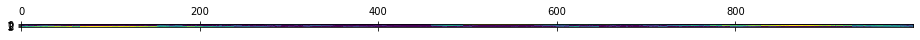

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs = np.array(g_obs)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 15

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_beta] = NumericArrayPattern (1000, 14, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [12]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(7781606.11534584, dtype=float64)

In [13]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

In [14]:
import inspect
lines = inspect.getsource(structure_model_lib.get_e_loglik)
print(lines)


def get_e_loglik(g_obs, e_log_pop_freq, e_log_1m_pop_freq, \
                    e_log_sticks, e_log_1m_sticks,
                    detach_ez):


    e_log_cluster_probs = \
        modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
                            e_log_sticks, e_log_1m_sticks)

    with loops.Scope() as s:
        s.e_loglik = 0.
        s.z_entropy = 0.
        for l in s.range(g_obs.shape[1]):
            e_loglik_l, z_entropy_l = get_e_loglik_l(g_obs[:, l],
                                    e_log_pop_freq[l], e_log_1m_pop_freq[l],
                                    e_log_cluster_probs, detach_ez)

            s.e_loglik += e_loglik_l
            s.z_entropy += z_entropy_l

    return s.e_loglik, s.z_entropy



# Define objective

In [15]:
optim_objective, vb_params_free = \
    structure_optimization_lib.define_structure_objective(g_obs,
                                                        vb_params_dict,
                                                        vb_params_paragami,
                                                        prior_params_dict, 
                                                        compile_hvp = True)

Compiling objective ...
Iter 0: f = 7781606.11534583
Compiling grad ...
Compiling hvp ...
Compile time: 78.8052secs


In [16]:
optim_objective.set_print_every(0)

# Derivative times

In [17]:
for i in range(5): 
    t0 = time.time()
    _ = optim_objective.f_np(vb_params_free)
    print(time.time() - t0)

5.4002745151519775
5.395970344543457
5.395780801773071
5.390069007873535
5.403618097305298


In [18]:
for i in range(5): 
    t0 = time.time()
    _ = optim_objective.grad_np(vb_params_free)
    print(time.time() - t0)

10.455130338668823
10.458614349365234
10.464349508285522
10.458301782608032
10.45302128791809


In [19]:
# for i in range(10): 
#     t0 = time.time()
#     _ = optim_objective.hvp_np(vb_params_free, vb_params_free)
#     print(time.time() - t0)

In [20]:
dp_prior_alpha = prior_params_dict['dp_prior_alpha']
allele_prior_alpha = prior_params_dict['allele_prior_alpha']
allele_prior_beta = prior_params_dict['allele_prior_beta']

# get initial moments from vb_params
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(
            vb_params_dict, gh_loc, gh_weights)

In [23]:
foo = cavi_lib.get_pop_beta_update1(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta)

foo = cavi_lib.get_pop_beta_update2(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta)

In [27]:
t0 = time.time()
foo = cavi_lib.get_pop_beta_update1(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta).block_until_ready()

foo = cavi_lib.get_pop_beta_update2(g_obs,
                        e_log_pop_freq, e_log_1m_pop_freq,
                        e_log_sticks, e_log_1m_sticks,
                        dp_prior_alpha, allele_prior_alpha,
                        allele_prior_beta).block_until_ready()

print(time.time() - t0)

12.923229932785034


In [33]:
update_pop_beta = jax.jit(cavi_lib.update_pop_beta)

In [34]:
_ = update_pop_beta(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    e_log_sticks, e_log_1m_sticks,
                    dp_prior_alpha, allele_prior_alpha,
                    allele_prior_beta)

In [37]:
t0 = time.time()
foo = update_pop_beta(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    e_log_sticks, e_log_1m_sticks,
                    dp_prior_alpha, allele_prior_alpha,
                    allele_prior_beta)

foo[0].block_until_ready()
time.time() - t0

11.781119346618652